In [1]:
# import the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

import statsmodels.api as sm
import scipy.stats as scs


from scipy.stats import norm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#upload the dataset
data = pd.read_csv("https://github.com/muluwork-shegaw/10Acad_week4/blob/master/ABAdRecall.csv?raw=true",error_bad_lines=False)

### Exploring the dataset

In [3]:
data.head() # glance  our dataset

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [4]:
data.describe() #description of the dataset

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [5]:
print('This dataset has '+str(data.shape[0])+' rows, and '
                         +str(data.shape[1])+ ' columns')


This dataset has 8077 rows, and 9 columns


In [6]:
data.info() #summery
# This shows us the different data types and number of non-null values in
#each columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


 **NB :**
- As we can show in the summery ,we have totally 8077 data and there is no null values.

In [7]:
data.nunique().sort_values(ascending=False) # number of unique  values in each vriable

auction_id     8077
device_make     270
hour             24
browser          15
date              8
platform_os       3
no                2
yes               2
experiment        2
dtype: int64

In [8]:
sample_data = data[np.logical_or(data['yes']==1,data['no']==1)]
sample_data.shape # the data which contain who has  animpression to answer for 

(1243, 9)

 **NB :**
- the data which contain who has an impression to answer for BIO questionarie and they actually reply as "yes" or "no"

### Overview

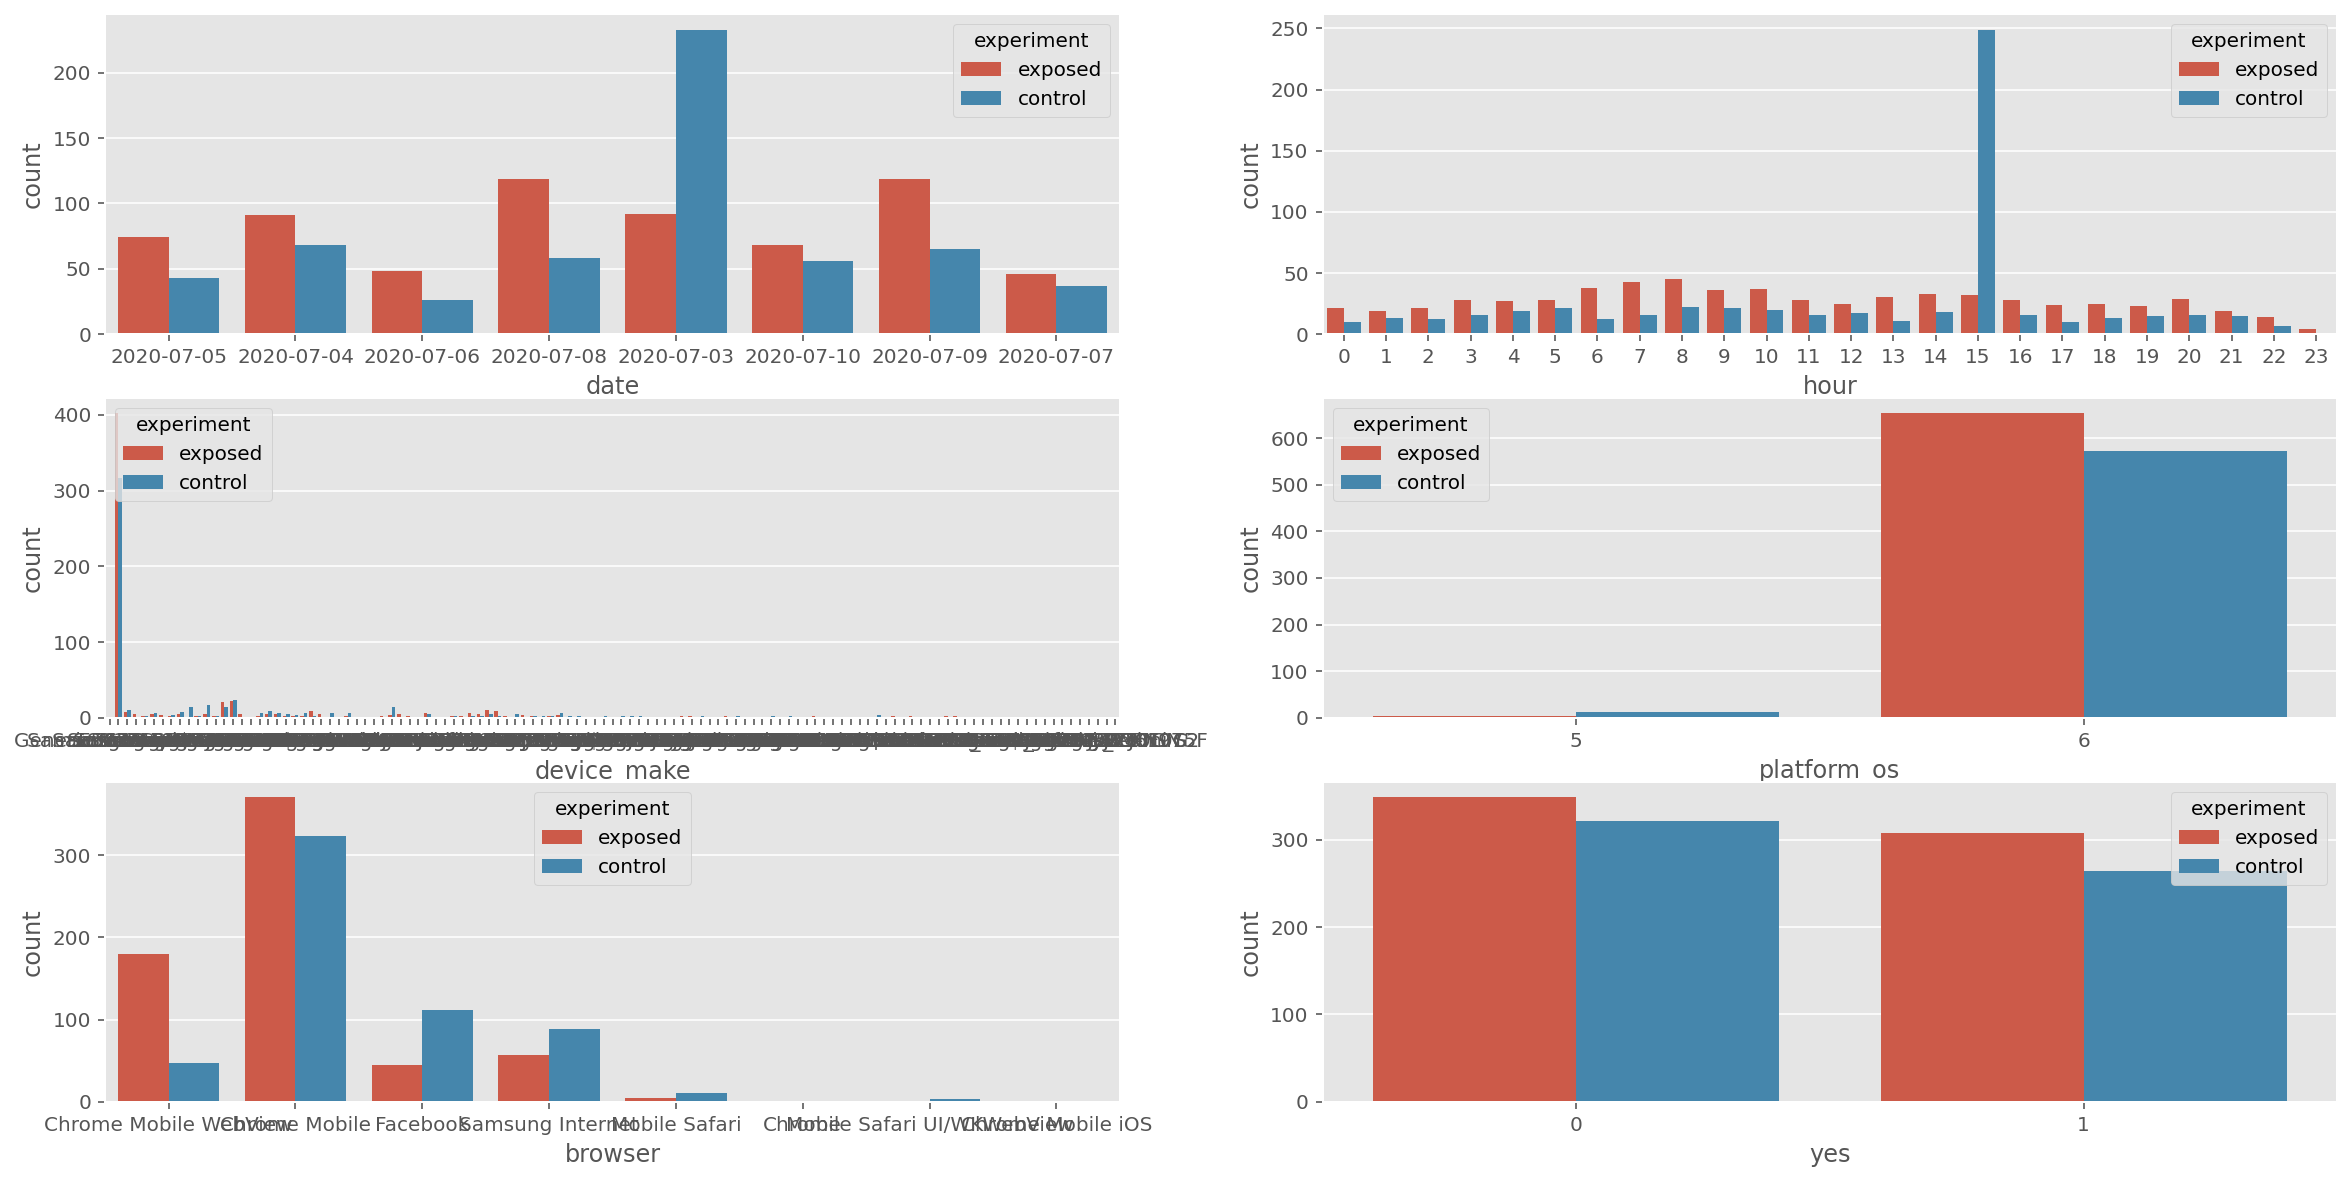

In [9]:
categorical_vars = ["date","hour","device_make","platform_os","browser","yes"]
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(20,10))
for i, var in enumerate(categorical_vars):
    row = i//2
    pos = i % 2
    plot = sns.countplot(x=var,hue="experiment", data=sample_data, ax=axs[row][pos])


In [10]:
# plot multiple hist in one graph
def multple_hist(data,bins,legend,color):
    for i in range(len(data)):
        plt.hist(data[i], bins, color=color[i], alpha=0.5)
        plt.legend(legend)
    plt.show()

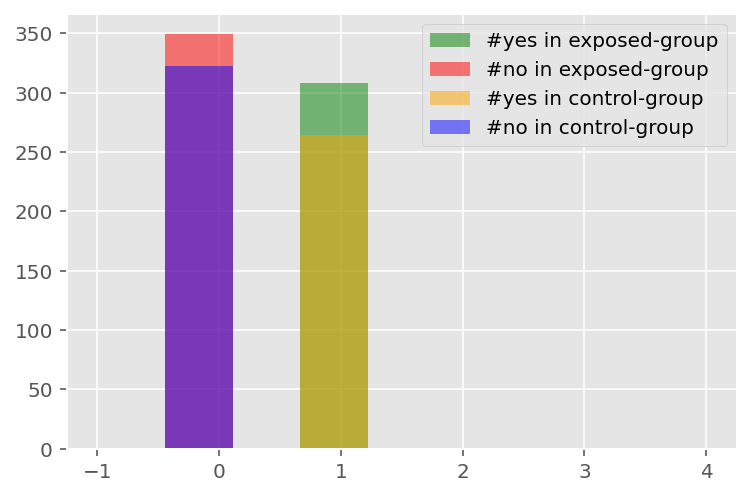

In [11]:
this_data = sample_data[['experiment','yes','no']]
exposed = this_data[this_data["experiment"] == "exposed"]
control = this_data[this_data["experiment"] == "control"]

datas = [exposed[exposed['yes']==1]['yes'],exposed[exposed['yes']==0]['yes'],
         control[control['yes']==1]['yes'],control[control['yes']==0]['yes']]

legend = ["#yes in exposed-group","#no in exposed-group",
          "#yes in control-group","#no in control-group"]
bins = np.linspace(-1, 4, 10)
color=["green","red","orange","blue"]

multple_hist(datas,bins,legend,color)

**NB:**
- The above figure shows us the distribution of the answers of the BIO(brand impact optimizer) for the users who are under the exposed and control group. 

- when we see histogram the count of yes is less than count no, which means most users don't know the brand smartAd.

**But when we compare the count of #yes in exposed and in control group ,the exposed group more know the brand smartAd than control group.** 
- #yes in exposed group is between  300 and 350
- #yes in control group is between  250 and 300


# Task 2: **Analysis**

## Task 2.1 : Classic A/B testing analysis





- Perform hypothesis testing: apply the classical p-value based algorithm and the  sequential A/B testing algorithm for which a starter code is provided..

Before running the test, we will know the baseline conversion rate and the desired lift or increase in awraeness of the brand that we would like to test.
- The baseline conversion rate is the current rate at which they answer "yes" under the existing design. 
- For our example, we want to use our test to confirm that the changes they make to the advertisment  will result in at least a 2% increase in awareness rate.

In [12]:
ab_summary = sample_data.pivot_table(values='yes', index='experiment', aggfunc=np.sum)
# add additional columns to the pivot table
ab_summary['total_ans'] = sample_data.pivot_table(values='yes', index='experiment', aggfunc=lambda x: len(x))
ab_summary['conversion_rate'] = sample_data.pivot_table(values='yes', index='experiment')

In [13]:
ab_summary

,yes,total_ans,conversion_rate
experiment,,,
control,264,586,0.450512
exposed,308,657,0.468798


In [14]:
ctrl_c = ab_summary['yes'][0]
ctrl_total = ab_summary['total_ans'][0]
ctrl_cr = ab_summary['conversion_rate'][0]

exp_c = ab_summary['yes'][1]
exp_total = ab_summary['total_ans'][1]
exp_cr = ab_summary['conversion_rate'][1]

d_cr = exp_cr-ctrl_cr
d_cr

0.018285619295484168

It looks like the difference in conversion rates between the two groups is 0.018 which is less than the lift we initially wanted of 0.02. This is not a good sign and this is not enough evidence for us to confidently go with the existing one. At this point we have not measured how confident we are in this result. This can be mitigated by looking at the distributions of the two groups.

###  Compare the Two Groups
We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip).

Text(0, 0.5, 'probability')

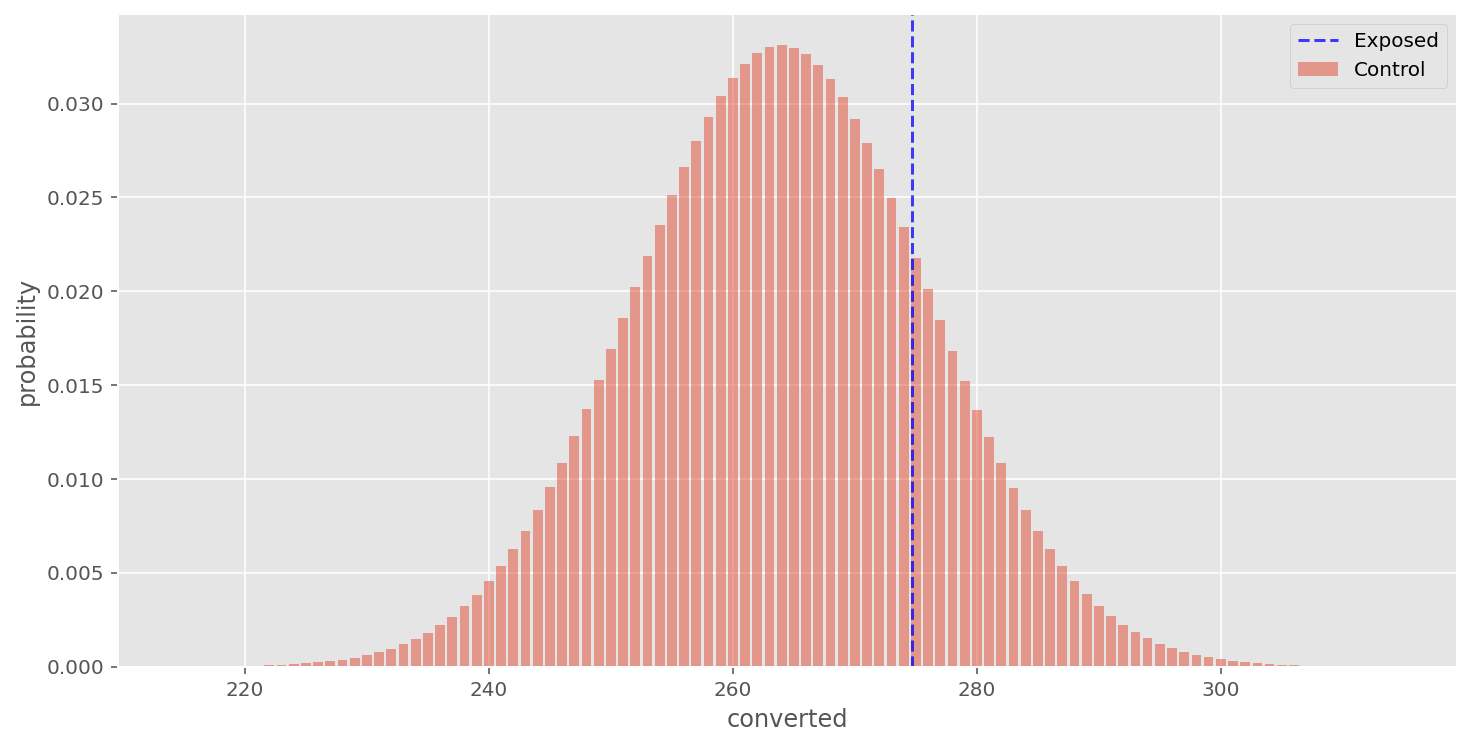

In [15]:
fig, ax = plt.subplots(figsize=(12,6))

x = np.linspace(ctrl_c-49, ctrl_c+50, 100)
y = scs.binom(ctrl_total, ctrl_cr).pmf(x)

ax.bar(x, y,label="Control", alpha=0.5)
ax.axvline(x=exp_cr * ctrl_total, c='blue',label ="Exposed", alpha=0.75, linestyle='--')

plt.legend()
plt.xlabel('converted')
plt.ylabel('probability')

The distribution for the control group is shown in red and the result from the test group is indicated by the blue dashed line. We can see that the probability of getting the result from the test group was very low. However, the probability does not convey the confidence level of the results. It does not take the sample size of our test group into consideration. Intuitively, we would feel more confident in our results as our sample sizes grow larger. Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

### Binomial Distribution


Text(0, 0.5, 'probability')

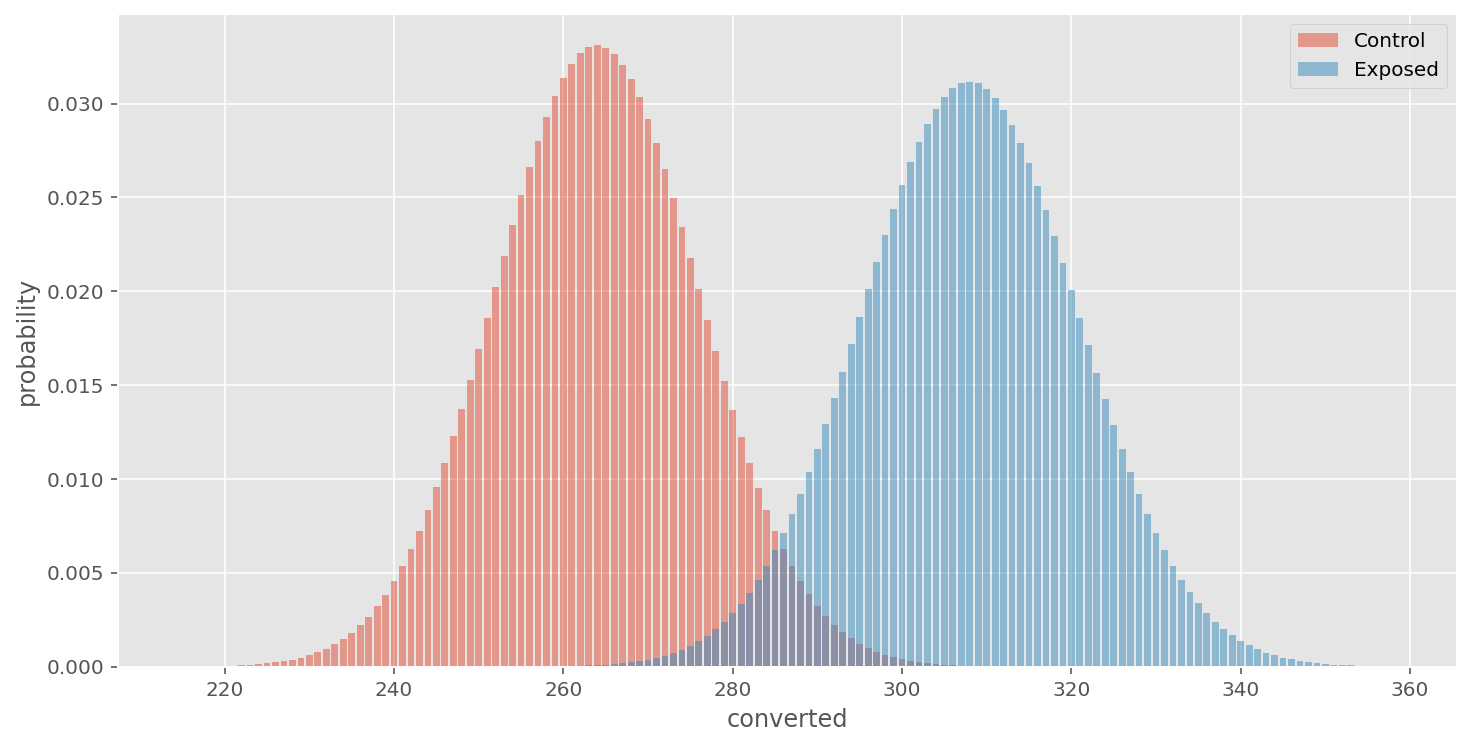

In [16]:
fig, ax = plt.subplots(figsize=(12,6))

xC = np.linspace(ctrl_c-49, ctrl_c+50, 100)
yC = scs.binom(ctrl_total, ctrl_cr).pmf(xC)
ax.bar(xC, yC, label = "Control",alpha=0.5)

xE = np.linspace(exp_c-49, exp_c+50, 100)
yE = scs.binom(exp_total, exp_cr).pmf(xE)
ax.bar(xE, yE, label = "Exposed",alpha=0.5)
plt.legend()
plt.xlabel('converted')
plt.ylabel('probability')

### Bernoulli Distribution and the Central Limit Theorem


Text(0, 0.5, 'probablity')

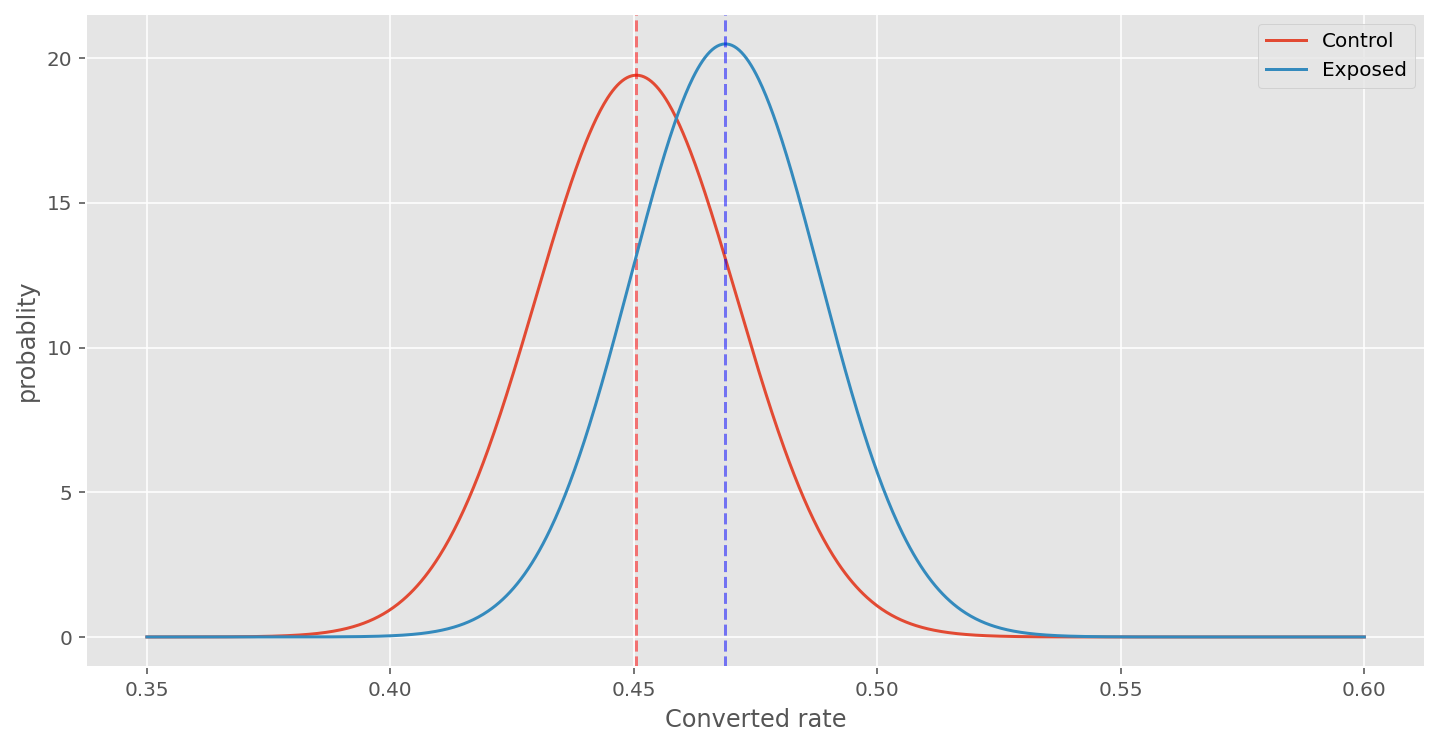

In [17]:
# standard error of the mean for both groups
std_C = np.sqrt(ctrl_cr * (1-ctrl_cr)) / np.sqrt(ctrl_total)
std_E = np.sqrt(exp_cr * (1-exp_cr)) / np.sqrt(exp_total)

# plot the null and alternative hypothesis
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(.35, .6, 1000)

yC = scs.norm(ctrl_cr, std_C).pdf(x)
ax.plot(x, yC,label = "Control")
ax.axvline(x=ctrl_cr, c='red', alpha=0.5, linestyle='--')

yE = scs.norm(exp_cr, std_E).pdf(x)
ax.plot(x, yE,label = "Exposed")
ax.axvline(x=exp_cr, c='blue', alpha=0.5, linestyle='--')

plt.legend()
plt.xlabel('Converted rate')
plt.ylabel('probablity')

The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to mean difference between the control and test group. d_cr is the distribution of the difference between random variables from the two groups.

- dcr = exp_cr - ctrl_cr 

### Compare the Null Hypothesis vs. the Alternative Hypothesis
- The null hypothesis is the position that the change in the design made for the test group would result in no change in the conversion rate.
- The alternative hypothesis is the opposing position that the change in the design for the test group would result in an improvement (or reduction) in the conversion rate.


the null hypothesis will be a normal distribution with a mean of zero and a standard deviation equal to the pooled standard error.

**Parameter of Interest**: p1 - p2, where p1 = control group and p2 = exposed group  

**Null Hypothesis, Ho:**   p1 - p2 = 0  
**Alternative Hypthosis, Ha:**  p1 - p2 $\neq$ 0  

**Data**:  from 657 users of exposed group. 46.88% has been show the brand ad with smartAd new creative. 
<br>from 586 users of control group. 45.05% has been show the brand ad with out the smartAd or with the existing system.

- the null hypothesis will be a normal distribution with a mean of zero and a standard deviation equal to the pooled standard error.

      Ho : mean_d = 0

      do ~ Normal(0,SE)

- The alternative hypothesis has the same standard deviation as the null hypothesis, but the mean will be located at the difference in the conversion rate, d_cr. This makes sense because we can calculate the difference in the conversion rates directly from the data, but the normal distribution represents the possible values our experiment could have given us.

      Ha : mean_d = pE - pC (exp_cr - ctrl_cr)
      da ~ Normal(d,SE)

- Now that we understand the derivation of the pooled standard error, we can just directly plot the null and alternative hypotheses for future experiments.

zscore is 0.646, with p-value 0.259


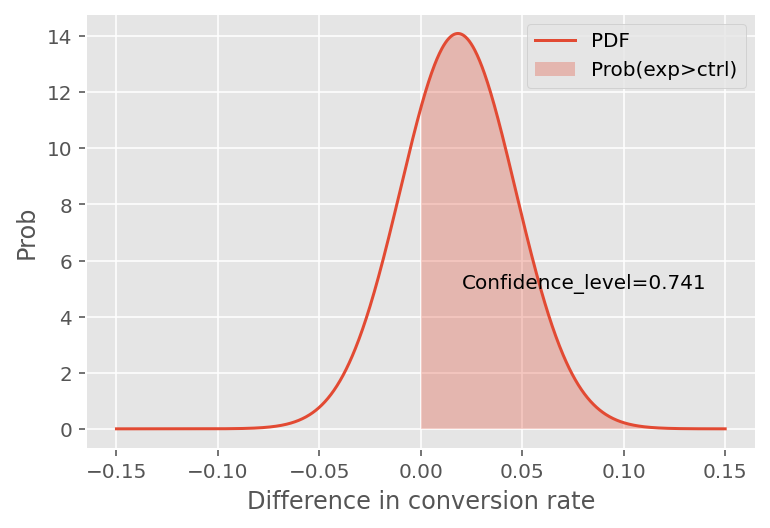

In [18]:
z_score = (d_cr) / np.sqrt(std_C**2 + std_E**2)
p = norm(d_cr, np.sqrt(std_C**2 + std_E**2))

x = np.linspace(-0.15, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(exp>ctrl)", alpha=0.3)
plt.annotate(f"Confidence_level={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

Using our classical approach so far, we would say that given the null hypothesis is true (tha impact of exposed is less then or equal to control), we would expect to get this result or a result more extreme 25.9% of the time. As that is a significant result (typically p > 5%), we fail to reject the null hypothesis, and state that we have weak evidence that Exposed  > Control.

We should explicitly note here that this is a one-tailed test - the question we’ve asked is if Exposed  > Control. An alterative is the two-tailed test, where we just want to discriminate that B is different to A. In that case, our p-value is actually 2 × 25.9 = 51.8  percent (as we have two tails, not one), and we would want more samples before rejecting the null hypothesis if we stick to the p-value of 0.05 threshold.



In [19]:
def get_confidence_ab_test(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(ctrl_c, ctrl_total, exp_c, exp_total))

0.7408273254172715


In [20]:
def get_p_value(a_c, num_a, b_c, num_b):
    a_cr = a_c / num_a
    b_cr = b_c / num_b
    std_a = np.sqrt(a_cr * (1 - a_cr) / num_a)
    std_b = np.sqrt(b_cr * (1 - b_cr) / num_b)
    z_score = (b_cr - a_cr) / np.sqrt(std_a**2 + std_b**2)
    return norm.sf(z_score)

print(get_p_value(ctrl_c, ctrl_total, exp_c, exp_total))

0.2591726745827285


In [21]:
# Draw 10000 samples of possible rates for a and b
n = 10000
rates_a = norm(ctrl_cr, std_C).rvs(n)
rates_b = norm(exp_cr, std_E).rvs(n)
b_better = (rates_b > rates_a).sum() / n
print(f"exposed is better than control {b_better * 100:0.1f}% of the time")

exposed is better than control 73.4% of the time


Which, rephrased to the language of before, is that Exposed = control 26.7% of the time, which is not statistically significant such that we fail to reject our hypothesis (that p1 = p2).



In [22]:
a_dist = np.zeros(ctrl_total)
a_dist[:ctrl_c] = 1
b_dist = np.zeros(exp_total)
b_dist[:exp_c] = 1
zscore, prob = scs.ttest_ind(a_dist, b_dist, equal_var=True)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -0.65, p-value is 0.519 (two tailed), 0.259 (one tailed)


In [23]:
sm.stats.ztest(b_dist,a_dist,alternative="larger")

(0.6452687398426953, 0.2593765234051756)

#### Sample size
- Are the number of data points in the experiment enough to make a reasonable judgement or should the company run a longer experiment? Remember that running the experiment longer may be costly for many reasons, so you should always optimize the number of samples to make a statistically sound decision.


In [24]:
def min_sample_size(ctrl_cr, d_cr, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        ctrl_cr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        d_cr (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (ctrl_cr + ctrl_cr+d_cr) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / d_cr**2)

    return min_N

In [25]:
min_sample_size = min_sample_size(ctrl_cr,d_cr)


print("The  minimum sample size is ",min_sample_size)

The  minimum sample size is  11660.61386940473



The calculated power for this sample size was approximately 0.80. Therefore, if our design change had an improvement in conversion of about 2 percent, we would need at least 11,660 samples in each group for a statistical power of at least 0.80.


## Task **2.2** Machine **Learning**

- Split the data into 70% training, 20% validation, and 10% test sets. 


In [26]:
# import necessary library
from sklearn import preprocessing 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

##### preprocessing the data

In [27]:
ml_data = sample_data

# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 

# Encode labels in all columns. 
ml_data['experiment']= label_encoder.fit_transform(ml_data['experiment'])
ml_data['date']= label_encoder.fit_transform(ml_data['date'])
ml_data['device_make']= label_encoder.fit_transform(ml_data['device_make'])
ml_data['browser']= label_encoder.fit_transform(ml_data['browser'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [28]:
ml_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2,2,4,6,2,0,1
16,008aafdf-deef-4482-8fec-d98e3da054da,1,1,16,13,6,1,1,0
20,00a1384a-5118-4d1b-925b-6cdada50318d,1,3,8,13,6,1,0,1
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,0,5,4,43,6,4,1,0
27,00ebf4a8-060f-4b99-93ac-c62724399483,0,0,15,13,6,1,0,1


In [29]:
ml_data.drop('auction_id', axis=1, inplace=True)
ml_data.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,experiment,date,hour,device_make,platform_os,browser,yes,no
2,1,2,2,4,6,2,0,1
16,1,1,16,13,6,1,1,0
20,1,3,8,13,6,1,0,1
23,0,5,4,43,6,4,1,0
27,0,0,15,13,6,1,0,1


In [30]:
# normalize  or scaling up our data
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
ml_data[:] = scaling.fit_transform(ml_data[:])
ml_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,experiment,date,hour,device_make,platform_os,browser,yes,no
2,1.0,0.285714,0.086957,0.035088,1.0,0.285714,0.0,1.0
16,1.0,0.142857,0.695652,0.114035,1.0,0.142857,1.0,0.0
20,1.0,0.428571,0.347826,0.114035,1.0,0.142857,0.0,1.0
23,0.0,0.714286,0.173913,0.377193,1.0,0.571429,1.0,0.0
27,0.0,0.000000,0.652174,0.114035,1.0,0.142857,0.0,1.0


In [31]:
train, validate, test = np.split(ml_data.sample(frac=1), [int(.7*len(ml_data)), int(.9*len(ml_data))])

In [32]:
train_invar = train[['experiment', 'date', 'hour', 'device_make', 'platform_os', 'browser']]
train_targ = train['yes']

test_invar = test[['experiment', 'date', 'hour', 'device_make', 'platform_os', 'browser']]
test_targ  = test['yes'] 

valid_invar = validate[['experiment', 'date', 'hour', 'device_make', 'platform_os', 'browser']]
valid_targ = validate['yes']

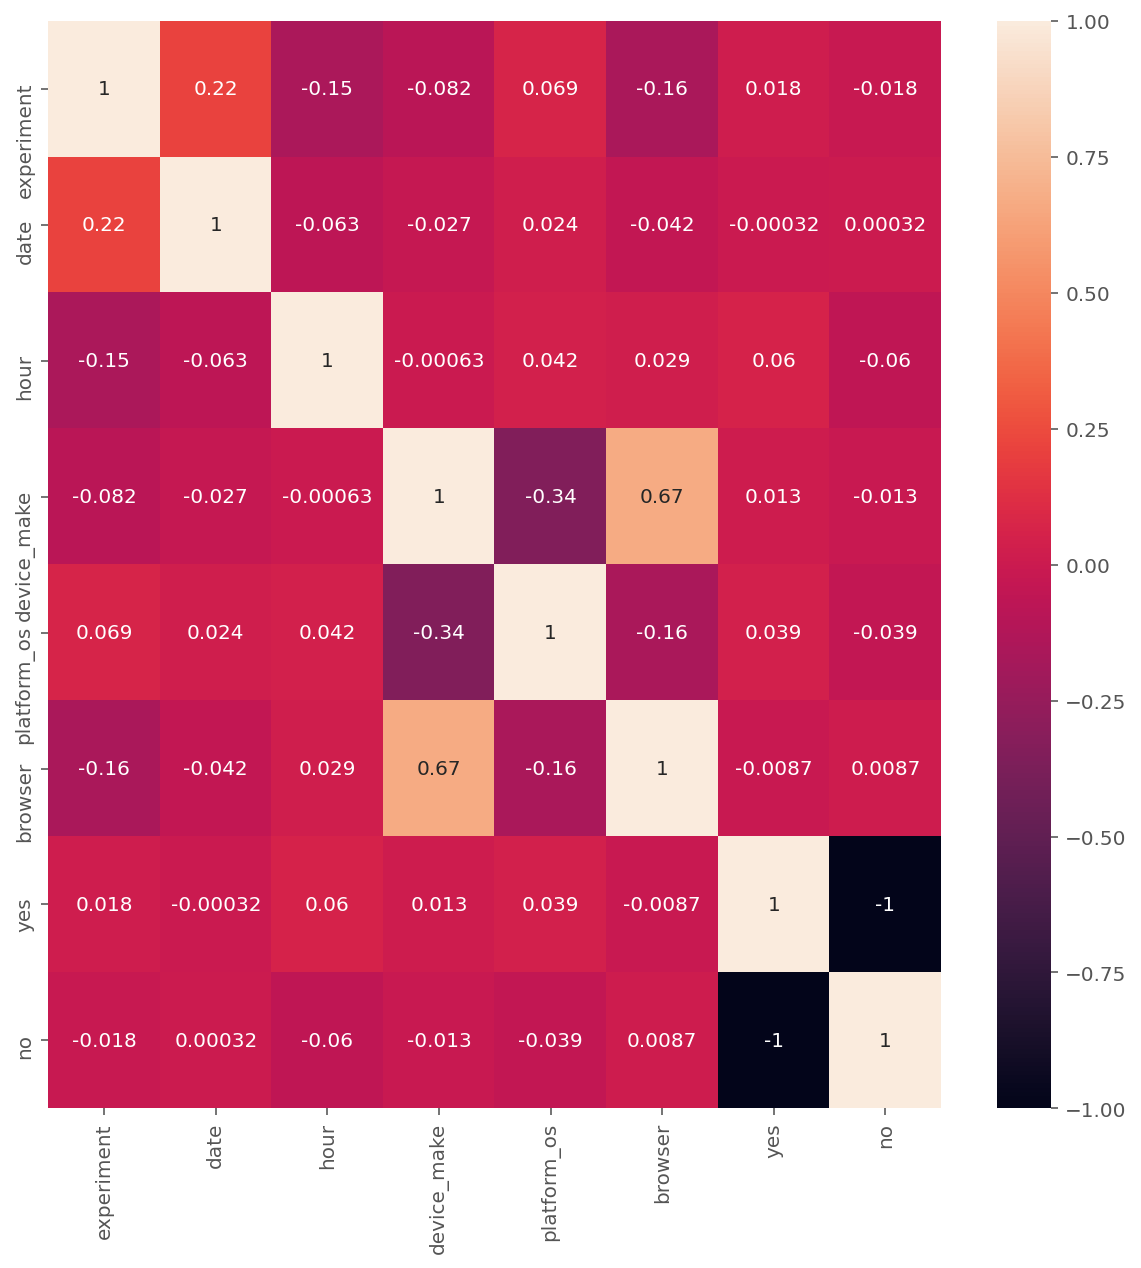

In [33]:
# to determine which parametes has more impact to the target variable
corr_mat = ml_data.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
g = sns.heatmap(ml_data[top_corr_features].corr(), annot= True)

As shown in the figure the target variable is more correlated with hour and platform os and it also correalted with experiment.

In [ ]:
for col in ml_data.columns:
  print(col,' : ', ml_data[col].nunique(), 'labels')

In [35]:
type(ml_data)

pandas.core.frame.DataFrame

#### Modeling

In [36]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

#### Logistic regression

In [37]:
from sklearn import linear_model
import scipy.stats as stat
import numpy as np
from sklearn.metrics import log_loss

class LogisticReg:
  
    def __init__(self):
        self.model = linear_model.LogisticRegression()

    def fit(self,X,y):
        self.X = X
        self.y = y
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij
    
    def get_summary(self):
        summary= pd.DataFrame()
        summary["features"] = self.X.columns
        summary["z_score"] = self.z_scores
        summary["p_value"] = self.p_values
        sns.barplot(summary["features"],summary["p_value"], data=summary)
        return summary
    def get_predicate(self,test):
        self.test = test       
        return self.model.predict(test)

    def get_accuracy(self,test_data,test_targ,k_fold):
        return cross_val_score(self.model,test_data, test_targ,cv=k_fold, scoring= 'accuracy').mean()
        
    def get_loss(self,valid_data,valid_targ,k_fold):
        return -(cross_val_score(self.model,valid_data, valid_targ,cv=k_fold, scoring= 'neg_log_loss').mean())
    def get_eff_model(self,test_data,test_targ,kfold):
        scoring = ["accuracy","roc_auc","neg_log_loss","r2",
             "neg_mean_squared_error","neg_mean_absolute_error"] 

        metrics = pd.DataFrame()
        metrics["model"] = ["Logistic regression"]
        for scor in scoring:
            score = []
            result = model_selection.cross_val_score(estimator= self.model, X=test_data, y=test_targ,cv=kfold,scoring=scor )
            score.append(result.mean())
            
            metrics[scor] =pd.Series(score)
        
        return metrics




#### Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier
import scipy.stats as stat
import numpy as np
from sklearn.metrics import log_loss

class Decision_Tree:
  
    def __init__(self):
        self.model = DecisionTreeClassifier()

    def fit(self,X,y):
        self.X = X
        self.y = y
        self.model.fit(X,y)

    def get_predicate(self,test):
        self.test = test       
        return self.model.predict(test)

    def get_accuracy(self,pred,test_data,test_targ,k_fold):
        return cross_val_score(self.model,test_data, test_targ,cv=k_fold, scoring= 'accuracy').mean()
        
    def get_loss(self,valid_data,valid_targ,k_fold):
        return -(cross_val_score(self.model,valid_data, valid_targ,cv=k_fold, scoring= 'neg_log_loss').mean())
    def get_eff_model(self,test_data,test_targ,kfold):
        scoring = ["accuracy","roc_auc","neg_log_loss","r2",
             "neg_mean_squared_error","neg_mean_absolute_error"] 

        metrics = pd.DataFrame()
        metrics["model"] = ["Decission Tree"]
        for scor in scoring:
            score = []
            result = model_selection.cross_val_score(estimator= self.model, X=test_data, y=test_targ,cv=kfold,scoring=scor )
            score.append(result.mean())
            
            metrics[scor] =pd.Series(score)
        
        return metrics
    def get_feature_impo(self):
        feat_importance = pd.Series(self.model.feature_importances_, index=self.X.columns)
        feat_importance.plot(kind='bar')
        plt.show()
        return feat_importance



#### XGBoost

In [39]:
import scipy.stats as stat
import numpy as np
from sklearn.metrics import log_loss

class XG_Boost:
  
    def __init__(self):
      data_dmatrix = xgb.DMatrix(data=train_invar,label=train_targ)
      self.model = xgb.XGBClassifier()

    def fit(self,X,y):
        self.X = X
        self.y = y
        self.model.fit(X,y)

    def get_predicate(self,test):
        self.test = test       
        return self.model.predict(test)

    def get_accuracy(self,pred,test_data,test_targ,k_fold):
        return cross_val_score(self.model,test_data, test_targ,cv=k_fold, scoring= 'accuracy').mean()
        
    def get_loss(self,valid_data,valid_targ,k_fold):
        return -(cross_val_score(self.model,valid_data, valid_targ,cv=k_fold, scoring= 'neg_log_loss').mean())
    def get_eff_model(self,test_data,test_targ,kfold):
        scoring = ["accuracy","roc_auc","neg_log_loss","r2",
             "neg_mean_squared_error","neg_mean_absolute_error"] 

        metrics = pd.DataFrame()
        metrics["model"] = ["XG_Boost"]
        for scor in scoring:
            score = []
            result = model_selection.cross_val_score(estimator= self.model, X=test_data, y=test_targ,cv=kfold,scoring=scor )
            score.append(result.mean())
            
            metrics[scor] =pd.Series(score)
        
        return metrics
    def get_feature_impo(self):
        feat_importance = pd.Series(self.model.feature_importances_, index=self.X.columns)
        feat_importance.plot(kind='bar')
        plt.show()
        return feat_importance

### Analysis

In [41]:
#create models
log_model = LogisticReg()
decision_tree = Decision_Tree()
xg_boost = XG_Boost()

#Train the model
log_model.fit(train_invar,train_targ)
decision_tree.fit(train_invar,train_targ)
xg_boost.fit(train_invar,train_targ)



#### importance of features

In [ ]:
#feature importance in logistic regression
log_model.get_summary()


In [ ]:
#feature importance in decision
decision_tree.get_feature_impo()

In [ ]:
#feature importance in logistic regression
xg_boost.get_feature_impo()

#### Compare the efficency of the model

In [46]:
from sklearn import model_selection

def eff_models(model, train_data, train_targ, kfold):
    scoring = ["accuracy","roc_auc","neg_log_loss","r2"] 

    eff_models = pd.DataFrame()
    eff_models["model"] = model
    for scor in scoring:
        score = []
        for mod in model:
           
            result = model_selection.cross_val_score(estimator= mod, X=train_data, y=train_targ,cv=kfold,scoring=scor )
            score.append(result.mean())
            
        eff_models[scor] =pd.Series(score)
        
    return eff_models


In [ ]:

error_metrics(model=[log_model.model,decision_tree.model,xg_boost.model],train_data = train_invar, train_targ = train_targ, kfold=k_fold)

#### validate the **data**

,model,accuracy,roc_auc,neg_log_loss,r2,neg_mean_squared_error,neg_mean_absolute_error
0,Logistic regression,0.601388,0.585924,-0.699913,-0.730622,-0.398612,-0.398612


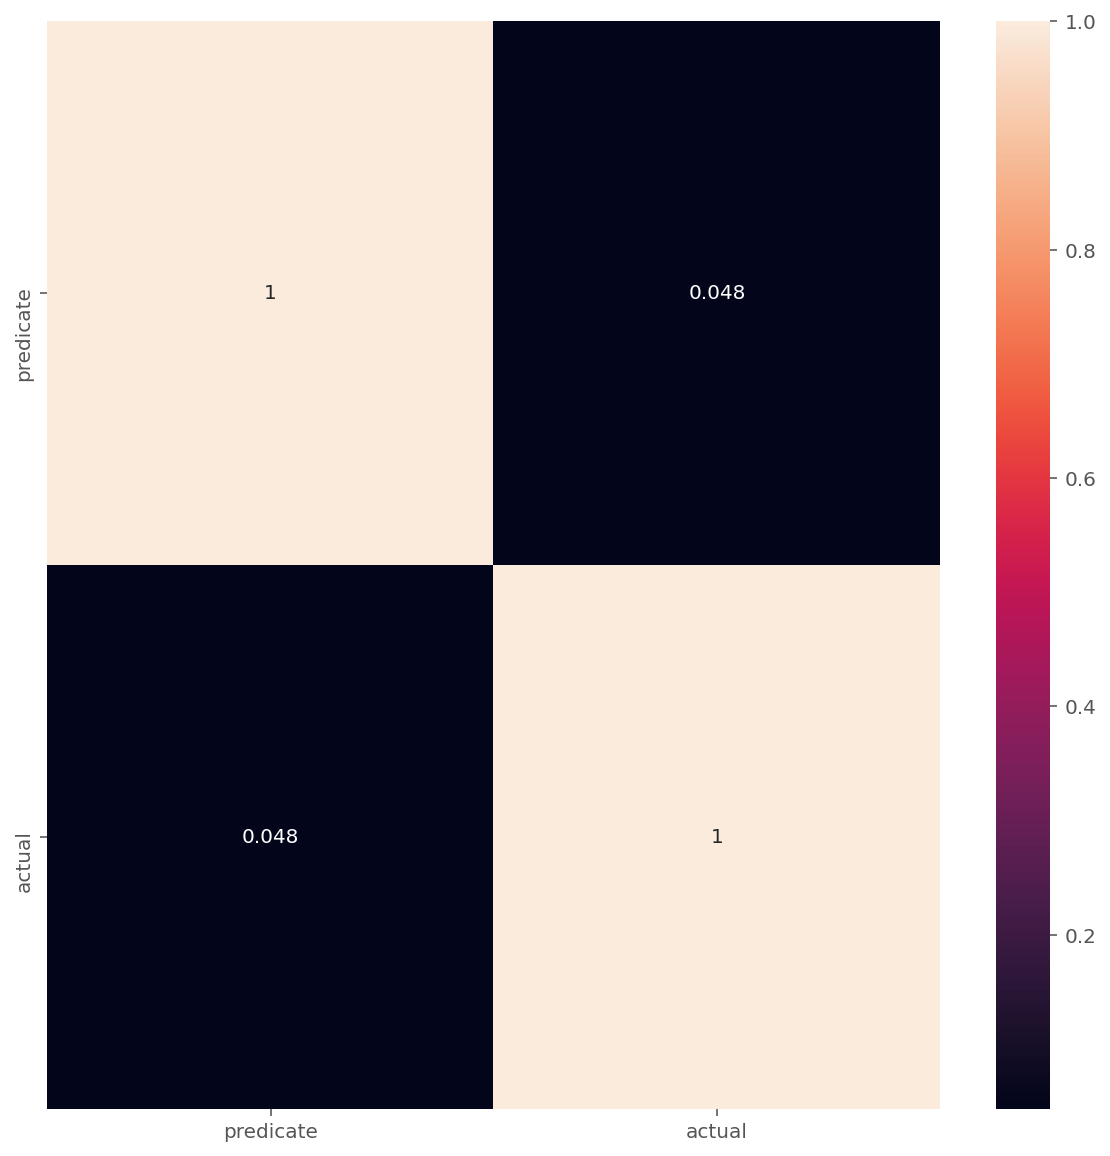

In [48]:
pred = log_model.get_predicate( valid_invar)

pre = pd.DataFrame()
pre["predicate"]=pred
pre["actual"] = train_targ

corr_mat = pre.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
sns.heatmap(pre[top_corr_features].corr(), annot= True)

log_model.get_eff_model(valid_invar,valid_targ,k_fold)


,model,accuracy,roc_auc,neg_log_loss,r2,neg_mean_squared_error,neg_mean_absolute_error
0,Decission Tree,0.52849,0.540394,-14.308793,-0.94663,-0.463347,-0.47151


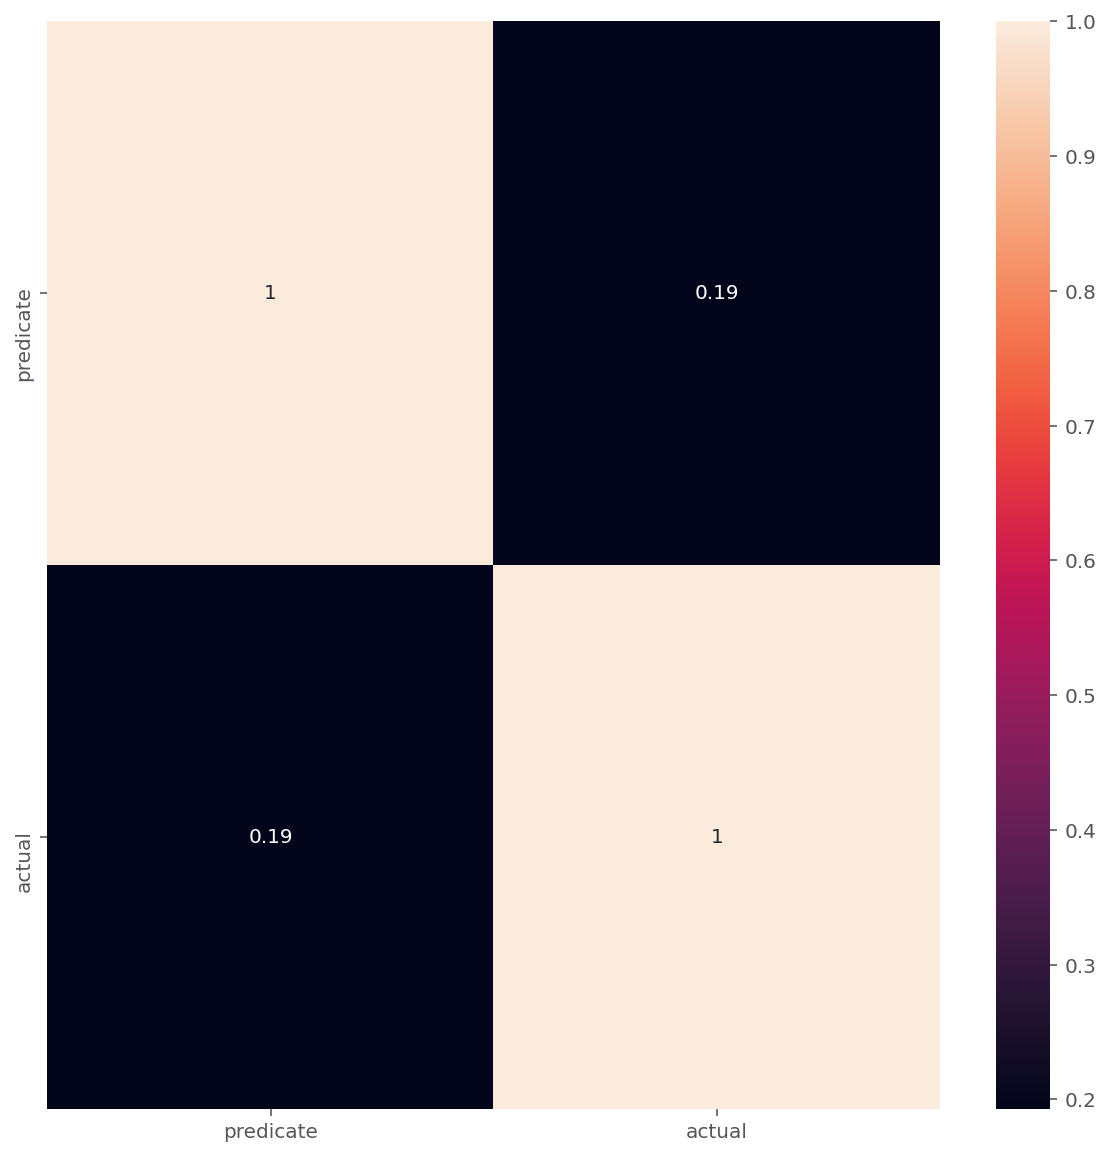

In [49]:
pred = decision_tree.get_predicate( valid_invar)

pre = pd.DataFrame()
pre["predicate"]=pred
pre["actual"] = train_targ

corr_mat = pre.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
sns.heatmap(pre[top_corr_features].corr(), annot= True)

decision_tree.get_eff_model(valid_invar,valid_targ,k_fold)

,model,accuracy,roc_auc,neg_log_loss,r2,neg_mean_squared_error,neg_mean_absolute_error
0,XG_Boost,0.560571,0.581411,-0.7864,-0.893353,-0.439429,-0.439429


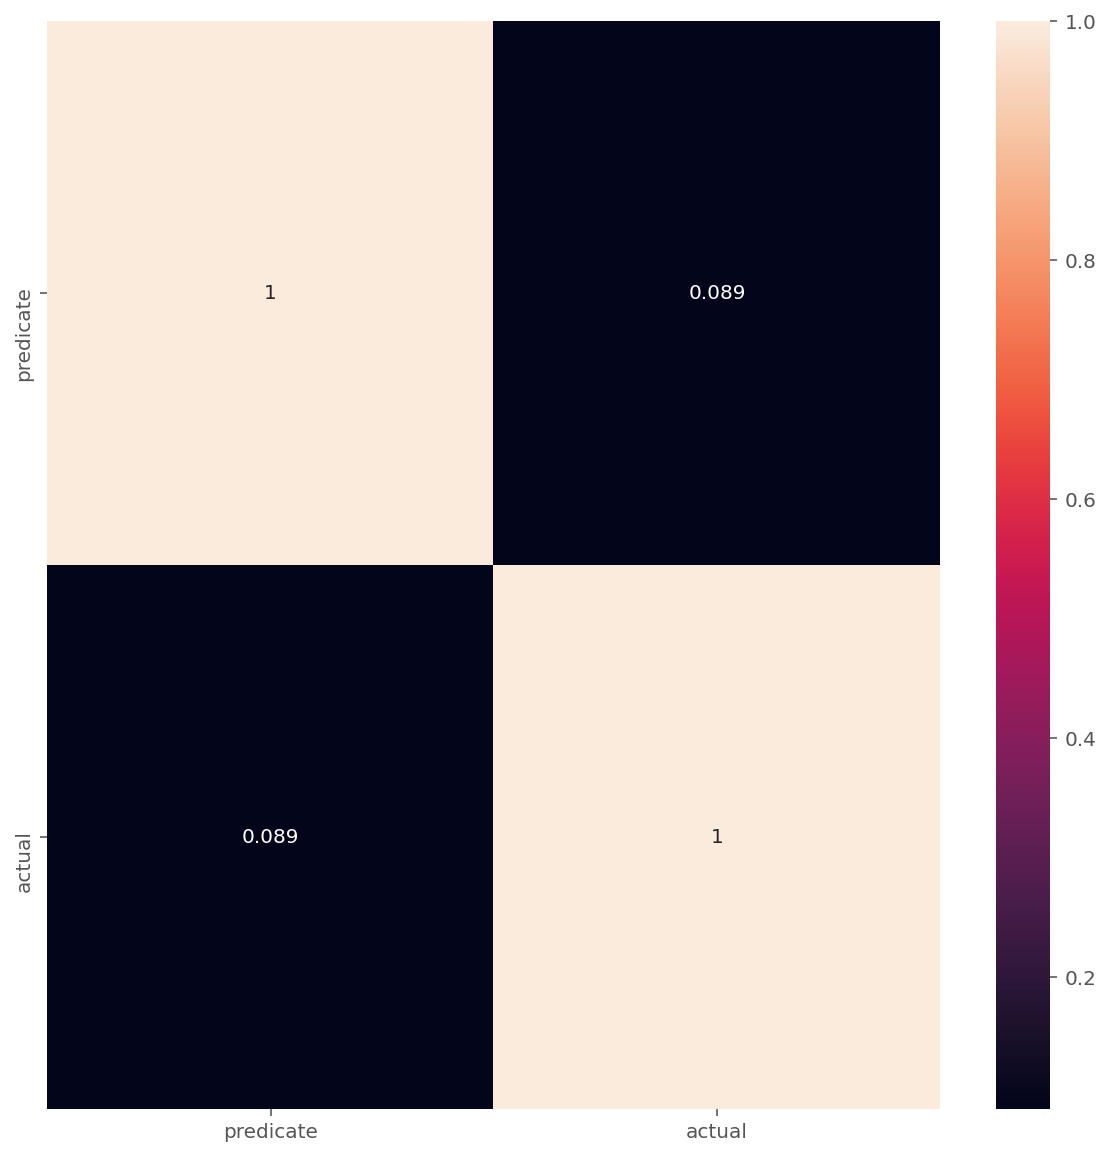

In [51]:
pred = xg_boost.get_predicate( valid_invar)

pre = pd.DataFrame()
pre["predicate"]=pred
pre["actual"] = train_targ

corr_mat = pre.corr()
top_corr_features = corr_mat.index
plt.figure(figsize=(10,10))
#plot heat map
sns.heatmap(pre[top_corr_features].corr(), annot= True)

xg_boost.get_eff_model(valid_invar,valid_targ,k_fold)

### Test the data

In [ ]:
from sklearn import metrics
pred = log_model.get_predicate( valid_invar)

